# **BANK MARKETING CAMPAIGN PREDICTIVE MODELING PROJECT**
### *Statistical + Predictive Models: Logistic Regression, Random Forest, XGBoost, Naive Bayes*

## **Project Overview**





### **Business Problem**
The Portuguese banking institution conducts periodic **marketing campaigns** (mainly through phone calls) to promote **term deposit subscriptions**.  
Despite repeated efforts, **conversion rates remain low**, and the management seeks data-driven insights to optimize targeting and improve campaign effectiveness.

Key business questions include:
- Which customer attributes (age, job, education, etc.) influence the likelihood of subscribing to a term deposit?
- What communication method or customer segment yields the **highest conversion rate**?
- Can we **predict** which customers are most likely to subscribe, allowing for **smarter campaign allocation**?

---

### **Project Objective**

This notebook aims to apply **predictive modeling** techniques to:
1. Build and evaluate multiple **machine learning models** — Logistic Regression, Random Forest, XGBoost, and Naive Bayes — to predict the probability of subscription.
2. Analyze **bias–variance tradeoffs**, perform **hyperparameter tuning**, and select a **champion model** using a train–validation–test approach.
3. Interpret the results to provide **actionable business recommendations** that can directly improve marketing ROI.

---

### **How This Analysis Helps the Business**

By accurately identifying which customers are most likely to respond positively to marketing efforts, the bank can:

- **Personalize communication strategies** (e.g., focus on high-likelihood segments).
- **Increase overall conversion rates** while lowering campaign costs.
- Use predictive insights to support **data-driven decision-making** across future marketing initiatives.

---

### **Project Structure (What This Notebook Does)**

1. **Data Preparation & Feature Engineering**  
   - Clean the dataset, handle missing values, and engineer meaningful business features (e.g., previous contact, month, balance log-transform).

2. **Model Development & Tuning**  
   - Train and evaluate Logistic Regression, Random Forest, XGBoost, and Naive Bayes models with GridSearchCV and cross-validation.

3. **Bias–Variance & Model Validation**  
   - Use learning curves to assess overfitting/underfitting, validate models, and identify the champion model.

4. **Model Comparison & Business Insights**  
   - Compare performance metrics across models and translate predictive insights into actionable business strategies.

---

### **Deliverables**
- Trained, validated, and tested predictive models
- Statistical and business insights on campaign effectiveness
- Visualizations (learning curves, feature importances, confusion matrices)
- Champion model for deployment or dashboard integration



## **1. Setup**

In [4]:
import warnings
warnings.filterwarnings('ignore')

# operational
import pandas as pd
import numpy as np

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Machine Learning Toolkit
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel, RFE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier


# For diagnostics
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Utility display
pd.set_option('display.max_columns', None)

## **2. Load Data**

In [7]:
df = pd.read_csv("bank_marketing_new.csv")
df.head()

,Unnamed: 0,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [8]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [9]:
print("Rows: ",df.shape[0])
print("Columns", df.shape[1])

Rows:  45211
Columns 17


In [ ]:
df['y'].value_counts(normalize=True)

,proportion
y,
0,0.883015
1,0.116985


## **3. Feature Enginnering (Common)**

In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [10]:
# Maping months with its appropiate number
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
df['month_num'] = df['month'].map(month_map)

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,month_num
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,5
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,5
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,5
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0,5
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0,5


In [11]:
# Boolean masking for customers who have been contacted
df['was_contacted_before'] = (df['pdays'] != -1 ).astype(int)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,month_num,was_contacted_before
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,5,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,5,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,5,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0,5,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0,5,0


In [12]:
# fix skewed data in balance
df['balance_log'] = np.log1p(df['balance'].clip(lower=0))
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,month_num,was_contacted_before,balance_log
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,5,0,7.670429
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,5,0,3.401197
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,5,0,1.098612
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0,5,0,7.317876
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0,5,0,0.693147


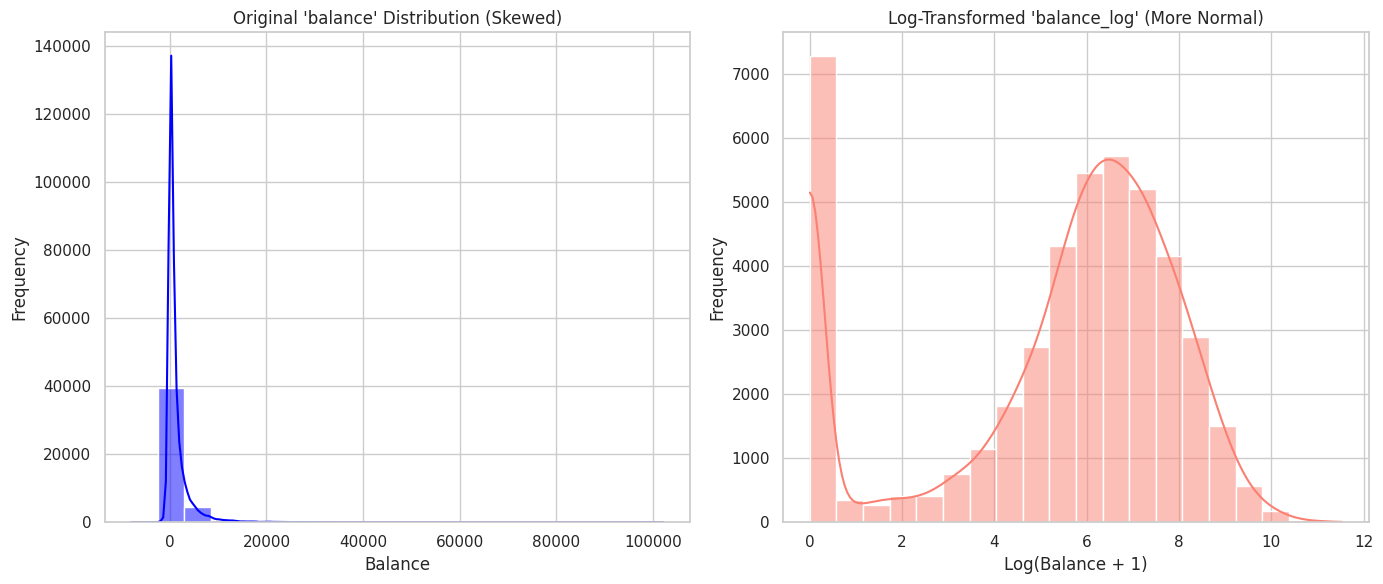

In [ ]:
# Set up the matplotlib figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot 1: Original 'balance' Distribution (Skewed)
sns.histplot(df['balance'], kde=True, ax=axes[0], bins=20, color='blue')
axes[0].set_title("Original 'balance' Distribution (Skewed)")
axes[0].set_xlabel('Balance')
axes[0].set_ylabel('Frequency')

# --- Plot 2: Log-Transformed 'balance_log' (More Normal)
sns.histplot(df['balance_log'], kde=True, ax=axes[1], bins=20, color='salmon')
axes[1].set_title("Log-Transformed 'balance_log' (More Normal)")
axes[1].set_xlabel('Log(Balance + 1)')
axes[1].set_ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

## **4. Train/Validation/Test Split**



### **Goal:**
 We split the dataset into three distinct sets to ensure robust model evaluation:
*  Training set: used to fit the model and tune parameters
*  Validation set: used to evaluate different models and tune hyperparameters
*  Test set: used *once* at the end to estimate true generalization performance
* The validation set ensures we do NOT overfit hyperparameters to the test data.

In [16]:
# Define feature matrix (X) and target vector (y)
X = df.drop(columns=['y'])
y = df['y']

display(X)
display(y)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,month_num,was_contacted_before,balance_log
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,5,0,7.670429
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,5,0,3.401197
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,5,0,1.098612
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,5,0,7.317876
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,5,0,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,unknown,11,0,6.716595
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,-1,0,unknown,11,0,7.455877
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,success,11,1,8.651025
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,unknown,11,0,6.505784


,y
0,0
1,0
2,0
3,0
4,0
...,...
45206,1
45207,1
45208,1
45209,0


In [17]:
# Step 1: Split into TEMP and TEST
# We keep aside 15% of the data as a final test set.
# Stratified sampling is used to maintain the same class distribution (important due to imbalance).

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

In [18]:
# Step 2: Split TEMP into TRAIN and VALIDATION
# From the remaining 85%, we take roughly 70% for training and 15% for validation.
# The ratio 0.1765 ensures: 0.85 × 0.1765 ≈ 0.15 (so test = val = 15% overall)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765,
    stratify=y_temp,
    random_state=42
)

In [19]:
# Step 3: Display split dimensions for explainability
# - The stratified split ensures both train/val/test reflect the same proportion of positive (1) and negative (0) labels.
# - We *never* touch the test set until we finalize the champion model.
# - This split enables unbiased performance comparison across different algorithms.


print("Dataset Shapes Summary:")
print(f"  Train: {X_train.shape}  → used for model fitting")
print(f"  Validation: {X_val.shape}  → used for hyperparameter tuning & model comparison")
print(f"  Test: {X_test.shape}  → held-out data for final performance evaluation")

Dataset Shapes Summary:
  Train: (31646, 18)  → used for model fitting
  Validation: (6783, 18)  → used for hyperparameter tuning & model comparison
  Test: (6782, 18)  → held-out data for final performance evaluation


## **5. Preprocessing Pipeline**


* The goal here is to prepare `numeric` and `categorical` data cleanly and consistently
* so that all downstream models receive a uniform, high-quality feature matrix.
* We'll use scikit-learn Pipelines and a ColumnTransformer for reproducibility and clarity.

In [ ]:
# Step 1: Identify numeric and categorical columns
# ------------------------------------------------------------

# Numeric columns: continuous or discrete numeric values
# We'll scale them to ensure fair contribution for regularized models (e.g., Logistic Regression).

num_cols = [
    'age',                    # client's age
    'day',                    # last contact day of the month
    'duration',               # duration of last contact in seconds
    'campaign',               # number of contacts performed during campaign
    'pdays',                  # days since last contact
    'was_contacted_before',   # if client is been contacted
    'previous',               # number of previous contacts
    'month_num',              # numeric encoding of contact month
    'balance_log'             # log-transformed balance to reduce skew
]

# Categorical columns: text labels that represent groups or categories
# We'll one-hot encode these so each category becomes a binary column.

cat_cols = [
    'job', 'marital', 'education', 'default',
    'housing', 'loan', 'contact', 'poutcome'
]

In [ ]:
# Step 2: Create numeric preprocessing pipeline
# ------------------------------------------------------------

# This handles missing values (median imputation) and scaling.
# Median is used because it's robust to outliers (balance, duration can be skewed).

numeric_pipleline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Replace missing numeric values with the median of each column
    ('scaler', StandardScaler())                    # Standardize numeric features (zero mean, unit variance), ensures all features contribute equally.
])

In [ ]:
# Step 3: Create categorical preprocessing pipeline
# ------------------------------------------------------------
# This handles missing categorical values and converts them into numerical form.

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),     # Replace missing category values (e.g., 'unknown') with 'MISSING'
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))    # Convert categorical columns into one-hot encoded binary columns, /
 ])                                                                            # handle_unknown='ignore' ensures unseen categories during inference won't break the model

In [ ]:
# Step 4: Combine both pipelines into a single ColumnTransformer
# ------------------------------------------------------------
# ColumnTransformer applies numeric and categorical pipelines to their respective columns in one step.
# The result is a single preprocessed feature matrix ready for model training.

preprocessor = ColumnTransformer([
    ('num', numeric_pipleline, num_cols),        # Apply numeric pipeline to numeric columns
    ('cat', categorical_pipeline, cat_cols)      # Apply categorical pipeline to categorical columns
])

**Explainability Note:**
*  This design allows us to easily extract and inspect the transformed feature names later.
*  We can call `preprocessor.get_feature_names_out()` after fitting to know which features each model sees.
*  It ensures full reproducibility — the exact same transformations will apply in cross-validation,
*   grid search, and final model deployment.
 ------------------------------------------------------------

* At this point, `preprocessor` can be used directly inside any scikit-learn Pipeline, for example:
* Pipeline([
     ('pre', preprocessor),
     ('clf', LogisticRegression())
])
* This modular approach ensures that raw data → preprocessed data → model training happens seamlessly.

## **Helper functions**

In [ ]:
def evaluate_model(name, model, X_val, y_val, X_test, y_test, results_df):
    """
    Evaluate a trained model on validation and test sets.
    Prints classification reports, plots confusion matrix,
    and appends evaluation metrics to a combined results_df.
    """

    # -----------------------------
    # Predictions & probabilities
    # -----------------------------
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Use predict_proba if available for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_val_proba = model.predict_proba(X_val)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):  # for models like SVM
        y_val_proba = model.decision_function(X_val)
        y_test_proba = model.decision_function(X_test)
    else:
        y_val_proba = None
        y_test_proba = None

    # -----------------------------
    # Compute metrics
    # -----------------------------
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    val_auc = roc_auc_score(y_val, y_val_proba) if y_val_proba is not None else np.nan
    test_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else np.nan

    # Store results in a row
    metrics = {
        "Model": name,
        "Val_Accuracy": val_acc,
        "Val_ROC_AUC": val_auc,
        "Test_Accuracy": test_acc,
        "Test_ROC_AUC": test_auc
    }

    # -----------------------------
    # Print reports
    # -----------------------------
    print(f"\n{name} Validation Classification Report:\n", classification_report(y_val, y_val_pred, digits=4))
    print(f"{name} Test Classification Report:\n", classification_report(y_test, y_test_pred, digits=4))

    # -----------------------------
    # Plot confusion matrix (Validation)
    # -----------------------------
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"{name} - Validation Confusion Matrix")
    plt.show()

    # -----------------------------
    # Append metrics to results_df (works for pandas >= 2.0)
    # -----------------------------
    results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)

    # Return updated results table
    return results_df

results_df = pd.DataFrame(columns=["Model", "Val_Accuracy", "Val_ROC_AUC", "Test_Accuracy", "Test_ROC_AUC"])



In [ ]:
# Function to Plot Learning Curves
def plot_learning_curve(estimator, X, y, title):
    """
    Generate a learning curve to visualize bias-variance tradeoff.

    A learning curve helps determine:
      - Whether the model is overfitting (high variance)
      - Whether the model is underfitting (high bias)
      - If more data would improve model performance.

    Parameters
    ----------
    estimator : sklearn estimator
        The pipeline or model to be evaluated.
    X : pandas.DataFrame
        Training feature set.
    y : pandas.Series
        Target labels.
    title : str
        Plot title (e.g., "Random Forest Learning Curve").
    """

    # Using sklearn's built-in learning_curve function to compute performance
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        cv=5,                        # 5-fold stratified CV
        scoring='roc_auc',           # Area Under ROC for consistency
        n_jobs=-1,                   # Utilize all CPU cores
        train_sizes=np.linspace(0.1, 1.0, 5)  # Evaluate on subsets of training data
    )


    # Compute average scores across folds
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)


    # Plot learning curve
    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, 'o-', label='Training ROC-AUC', color='blue')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation ROC-AUC', color='orange')
    plt.fill_between(train_sizes,
                     train_mean - np.std(train_scores, axis=1),
                     train_mean + np.std(train_scores, axis=1),
                     alpha=0.1, color='blue')
    plt.fill_between(train_sizes,
                     val_mean - np.std(val_scores, axis=1),
                     val_mean + np.std(val_scores, axis=1),
                     alpha=0.1, color='orange')
    plt.xlabel("Training Set Size")
    plt.ylabel("ROC-AUC")
    plt.title(title)
    plt.legend(loc='best')
    plt.show()



# Initialize Comparison DataFrame

# This DataFrame will collect metrics from every model in a standardized format.
# Each row represents one model's performance summary on validation and test data.
# At the end of the notebook, this will be used to select the "Champion Model."

results_df = pd.DataFrame(columns=[
    'Model',           # Model name (e.g., Logistic Regression, Random Forest)
    'Val_Accuracy',    # Validation Accuracy
    'Val_ROC_AUC',     # Validation ROC-AUC score
    'Test_Accuracy',   # Test Accuracy
    'Test_ROC_AUC'     # Test ROC-AUC score
])

print("Helper functions and results dataframe initialized successfully.")

Helper functions and results dataframe initialized successfully.


In [ ]:

def get_importances(gs_object):
    """
    Extracts, cleans, and formats feature importances from a fitted
    GridSearchCV Random Forest pipeline.

    Assumes pipeline steps are named 'pre' (preprocessor) and
    'clf' (classifier).

    Args:
        gs_object (GridSearchCV): The fitted GridSearchCV object.

    Returns:
        pandas.DataFrame: A sorted DataFrame with 'feature', 'importance',
                          and 'importance_pct' columns.
    """

    # 1. Get model parts from the best pipeline
    best_pipeline = gs_object.best_estimator_
    classifier = best_pipeline.named_steps['clf']
    preprocessor = best_pipeline.named_steps['pre']

    # 2. Get feature names and importances
    try:
        feature_names = list(preprocessor.get_feature_names_out())
    except AttributeError:
        print("Error: Could not get feature names. Ensure scikit-learn >= 1.0.")
        return None

    importances = classifier.feature_importances_

    # 3. Create the DataFrame
    imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })

    # 4. Clean names and create percentage column
    imp_df['feature'] = imp_df['feature'].str.replace('num__', '', regex=False)
    imp_df['feature'] = imp_df['feature'].str.replace('cat__', '', regex=False)
    imp_df['importance_pct'] = imp_df['importance'] * 100

    # 5. Sort by percentage and return
    imp_df = imp_df.sort_values('importance_pct', ascending=False).reset_index(drop=True)

    return imp_df

**Interpretation Guide:**
* High training score, low validation score → Overfitting (High Variance)
* Both low → Underfitting (High Bias)
* Small gap but decent score → Good balance
* If both plateau early → More data unlikely to help

| Function                | Purpose                                         | Explanation                                                                                                         |
| ----------------------- | ----------------------------------------------- | ------------------------------------------------------------------------------------------------------------------- |
| `evaluate_model()`      | Evaluate models on validation and test data     | Prints detailed classification reports, plots confusion matrices, and logs results into a DataFrame for comparison. |
| `plot_learning_curve()` | Visualize model’s bias–variance characteristics | Uses cross-validation to plot ROC-AUC across increasing training sizes, helping diagnose overfitting/underfitting.  |
| `results_df`            | Central results log                             | Stores metrics (accuracy, ROC-AUC) for each model, enabling easy champion model selection later.                    |


## **MODEL 1: LOGISTIC REGRESSION**

### **STEP 1: Check Model Assumptions (Multicollinearity)**

*  Logistic Regression assumes:
> * Linearity between continuous predictors and the logit of the outcome
> * No or low multicollinearity between predictors
> * Independence of observations

> We'll check multicollinearity among numeric features using **VIF (Variance Inflation Factor)**.

> **A VIF > 10** generally indicates high multicollinearity that may distort model estimates.

In [ ]:
# Prepare numeric data by imputing missing values using median strategy
num_data = pd.DataFrame(
    SimpleImputer(strategy='median').fit_transform(X_train[num_cols]),
    columns=num_cols
)

# Compute VIF for each numeric variable
vif = pd.Series(
    [variance_inflation_factor(num_data.values, i) for i in range(num_data.shape[1])],
    index=num_data.columns
)
print("VIF Values:\n", vif)

VIF Values:
 age                     8.973787
day                     4.319572
duration                1.934523
campaign                1.844991
pdays                   4.853636
was_contacted_before    6.118441
previous                1.838098
month_num               6.717375
balance_log             4.304161
dtype: float64


**Interpretation Tip**:
*  If any variable’s VIF > 10, consider removing or combining features.
* Logistic Regression performance may degrade if strong multicollinearity exists.

**Multicollinearity Check (VIF Analysis):**
* Variance Inflation Factor (VIF) was calculated for all numeric predictors to assess multicollinearity.
* The results show that most variables have VIF values below 5, indicating acceptable levels of correlation.
* A few variables (`age`, `month_num`, and `was_contacted_before`) have higher VIFs between 6–9, suggesting moderate multicollinearity.
* However, none exceed the critical threshold of 10, meaning no severe redundancy among predictors.
* Therefore, all features were retained.
* Additionally, the use of L2 regularization in Logistic Regression further helps mitigate any residual multicollinearity impact.

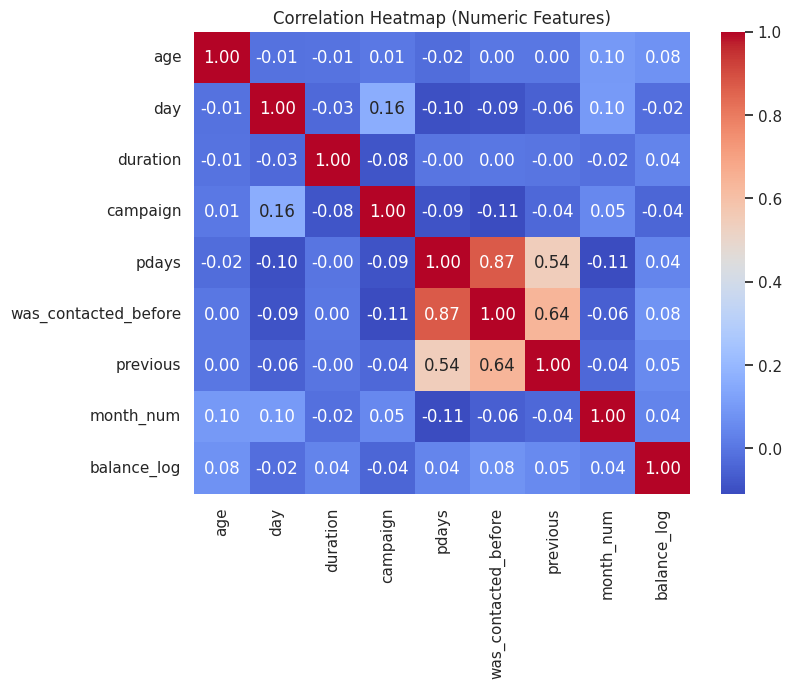

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(num_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

**Correlation & Multicollinearity Insights**

The correlation heatmap shows a strong positive correlation between **`pdays`** and **`was_contacted_before`** (r ≈ 0.87).  
This makes sense — both represent whether a customer was previously contacted, with `was_contacted_before` being a binary flag derived from `pdays`.

Including both may introduce redundant information, inflating variance and potentially impacting coefficient stability in linear models.

**Decision:**
- For *Logistic Regression* (linear models), I will **drop `was_contacted_before`** to reduce redundancy.  
- For *Random Forest* and *XGBoost* (tree-based models), I will **keep both**, since tree models handle correlated variables naturally.  

This ensures each model type is optimized for its assumptions while maintaining interpretability and predictive stability.


In [ ]:
# Preparing linear-model-specific datasets by dropping the redundant binary flag
# -----------------------------------------------------------------

# We remove 'was_contacted_before' for linear models to avoid multicollinearity
# since it is highly correlated with 'pdays' (derived from it).
X_train_lin = X_train.drop(columns=['was_contacted_before'])
X_val_lin   = X_val.drop(columns=['was_contacted_before'])
X_test_lin  = X_test.drop(columns=['was_contacted_before'])


# Update numeric feature list for the linear models
num_cols_lin = [c for c in num_cols if c != 'was_contacted_before']

In [ ]:
# STEP 1️: Check Model Assumptions (Multicollinearity using VIF)
# -----------------------------------------------------------------
# Prepare numeric data by imputing missing values using median strategy

num_data_lin = pd.DataFrame(
    SimpleImputer(strategy='median').fit_transform(X_train_lin[num_cols_lin]),
    columns=num_cols_lin
)

vif_lin = pd.Series(
    [variance_inflation_factor(num_data_lin.values, i) for i in range(num_data_lin.shape[1])],
    index=num_data_lin.columns
)

print("VIF Values (linear-model features):\n", vif_lin)

VIF Values (linear-model features):
 age            8.971120
day            4.319286
duration       1.934508
campaign       1.833950
pdays          1.644211
previous       1.547756
month_num      6.693629
balance_log    4.283683
dtype: float64


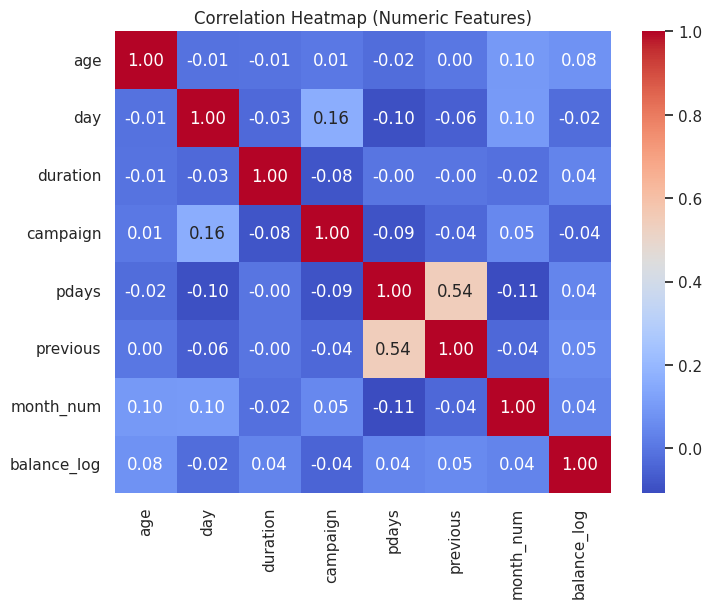

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(num_data_lin.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [ ]:
# STEP 2️: Build Pipeline and Preprocessing Setup (for linear model)
# -----------------------------------------------------------------
# Build a ColumnTransformer that uses the updated numeric feature list

numeric_pipeline_lin = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


# Reuse categorical pipeline (no change)
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


preprocessor_lin = ColumnTransformer([
    ('num', numeric_pipeline_lin, num_cols_lin),
    ('cat', categorical_pipeline, cat_cols)
])


# Logistic regression pipeline: preprocessing -> classifier (class_weight to handle imbalance)
logreg_pipe = Pipeline([
    ('pre', preprocessor_lin),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

In [ ]:
# STEP 3: Define Hyperparameter Grid for Tuning

param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],   # inverse regularization strength
    'clf__penalty': ['l2'],         # use L2 regularization
    'clf__solver': ['saga']         # saga supports large datasets and 'l2'
}

In [ ]:
# STEP 4️⃣: Perform Grid Search with Cross-Validation (on cleaned train set)

gs_log = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit on the dataset without 'was_contacted_before'
gs_log.fit(X_train_lin, y_train)

# Output best parameters found during cross-validation
print("Best Logistic Regression Parameters:", gs_log.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Logistic Regression Parameters: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'saga'}


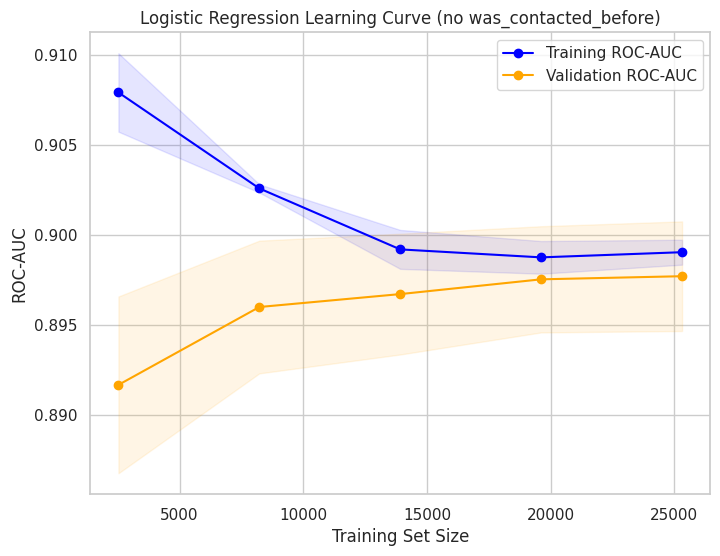

In [ ]:
# STEP 5️: Evaluate Bias–Variance Tradeoff via Learning Curve
# Use the cleaned training set for learning curve analysis

plot_learning_curve(
    gs_log.best_estimator_,
    X_train_lin,
    y_train,
    "Logistic Regression Learning Curve (no was_contacted_before)"
)

### **Logistic Regression Learning Curve Interpretation**

The learning curve shows a **healthy convergence** between training and validation ROC-AUC scores.

- The **training AUC** starts slightly higher (~0.91) but stabilizes near **0.898** as more data is used.  
- The **validation AUC** improves with larger sample size, approaching **0.895**.  
- The small and consistent gap (<0.01) between curves indicates **low variance (no overfitting)** and **low bias (no underfitting)**.

Overall, the logistic regression model demonstrates **strong generalization** and **stable predictive performance**.  
Feature simplification (dropping `was_contacted_before`) and **L2 regularization** effectively mitigated multicollinearity and stabilized learning.



Logistic Regression Validation Classification Report:
               precision    recall  f1-score   support

           0     0.9653    0.8320    0.8937      5989
           1     0.3794    0.7746    0.5093       794

    accuracy                         0.8253      6783
   macro avg     0.6724    0.8033    0.7015      6783
weighted avg     0.8967    0.8253    0.8487      6783

Logistic Regression Test Classification Report:
               precision    recall  f1-score   support

           0     0.9660    0.8344    0.8954      5989
           1     0.3835    0.7781    0.5137       793

    accuracy                         0.8278      6782
   macro avg     0.6747    0.8062    0.7045      6782
weighted avg     0.8979    0.8278    0.8507      6782



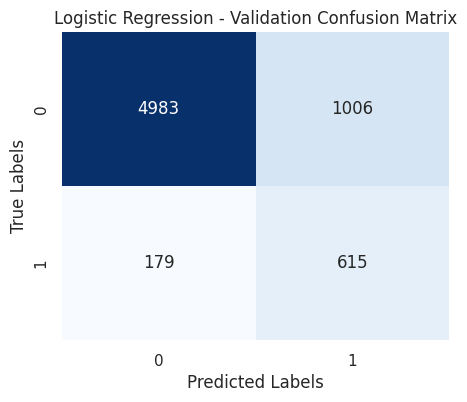

,Model,Val_Accuracy,Val_ROC_AUC,Test_Accuracy,Test_ROC_AUC
0,Logistic Regression,0.825299,0.888876,0.827779,0.886832


In [ ]:
# STEP 6️: Evaluate Model Performance on Validation and Test Data
# Evaluate on the cleaned validation and test partitions

results_df = evaluate_model(
    "Logistic Regression",
    gs_log.best_estimator_,
    X_val_lin, y_val,
    X_test_lin, y_test,
    results_df
)

results_df


### **Logistic Regression (No `was_contacted_before`) — Model Summary**



#### **Learning Curve**
- **Training ROC-AUC (~0.90–0.91)** is slightly higher than **validation ROC-AUC (~0.89)** → shows **low variance** and **stable generalization**.  
- The small gap indicates **no severe overfitting**; the model learns consistently with increasing data.

---

#### **Overall Metrics**
| Metric | Validation | Test |
|---------|-------------|------|
| **Accuracy** | 0.825 | 0.828 |
| **ROC-AUC** | 0.889 | 0.887 |

- **High and consistent AUC** across validation and test → model has **good discriminatory power** and **robust generalization**.  
- Accuracy around **82–83%** indicates solid baseline performance for a simple linear model.

---

#### **Classification Report (Test Set)**
| Class | Precision | Recall | F1-score | Interpretation |
|-------|------------|---------|-----------|----------------|
| **0 (No Subscription)** | 0.966 | 0.834 | 0.895 | Excellent at correctly identifying non-subscribers. |
| **1 (Subscription)** | 0.384 | 0.778 | 0.514 | Captures ~78% of real subscribers but with moderate precision (some false positives). |

- **High recall for class 1** → model identifies most potential subscribers (good for marketing reach).  
- **Moderate precision** → some false alarms; threshold tuning could balance this trade-off.

---

#### **Confusion Matrix (Validation)**
| | Pred 0 | Pred 1 |
|--|--:|--:|
| **True 0** | 4983 | 1006 |
| **True 1** | 179 | 615 |

- **615 true positives** and **179 false negatives** → captures majority of actual subscribers.  
- **1006 false positives** → manageable cost if follow-up campaigns are inexpensive.

---

#### **Interpretation**
- Model generalizes well and performs consistently across datasets.  
- **Strong recall** makes it ideal for marketing scenarios prioritizing lead coverage over precision.  
- Serves as a **reliable baseline** for comparison with more complex models like Random Forest or XGBoost.  


##  **MODEL 2: RANDOM FOREST**

In [ ]:
# -------------------------
# 1) Pipeline definition

# We wrap the preprocessing and the classifier in a Pipeline so that:
# - preprocessing (imputation/scaling/one-hot) is applied identically in CV folds
# - we avoid data leakage and ensure reproducibility

rf_pipe = Pipeline([
    ('pre', preprocessor),                            # ColumnTransformer defined earlier: numeric scaler + categorical OHE
    ('clf', RandomForestClassifier(random_state=42))  # classifier placeholder (params tuned by GridSearchCV)
])

In [ ]:
# 2) Hyperparameter grid

# Define a grid for GridSearchCV. These hyperparameters are high-impact for RF:
# - n_estimators: number of trees; more trees -> lower variance but slower
# - max_depth: controls tree depth; smaller depth -> less overfitting (bias increases)
# - min_samples_split / min_samples_leaf: regularize tree growth -> reduce overfitting
# - class_weight: 'balanced' helps with class imbalance by weighting classes inversely to frequency

param_grid_rf = {
    'clf__n_estimators': [200, 700],           # reasonable starting choices
    'clf__max_depth': [5, 10, 15, 20, None],   # None = fully grown trees
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__class_weight': ['balanced']          # use 'balanced' to address class imbalance
}


In [ ]:
# 3) GridSearchCV (tuning)

# GridSearchCV performs exhaustive search over the param_grid using Stratified K-Fold internally (cv=5).
# scoring='roc_auc' is used because the dataset is imbalanced and ROC-AUC is robust.
# n_jobs=-1 uses all available cores to speed up the search.

gs_rf = GridSearchCV(rf_pipe, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

# Fit GridSearch on the training set (this will train many models and find best params)
gs_rf.fit(X_train, y_train)

# Print best params and the best cross-validated score found
print("Best RF params:", gs_rf.best_params_)
print("Best CV ROC-AUC:", gs_rf.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best RF params: {'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 700}
Best CV ROC-AUC: 0.9269902706714713


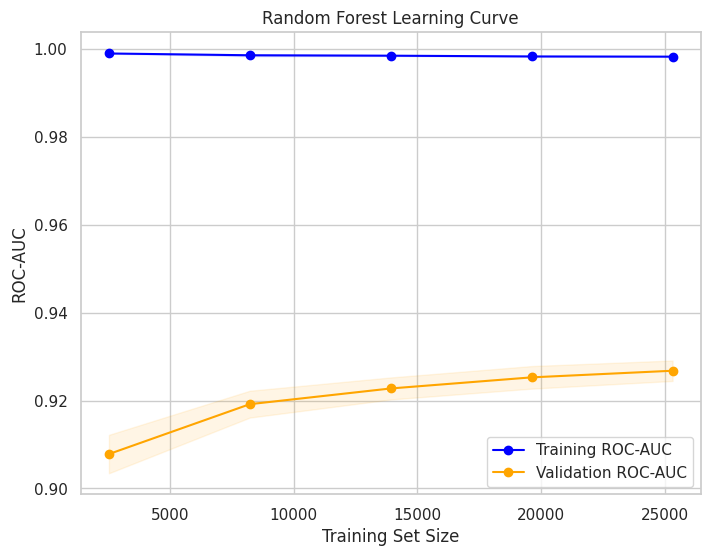

In [ ]:
# 4) Bias-Variance Analysis

# Plot learning curve for the best estimator to inspect bias/variance behavior.
# The helper function `plot_learning_curve` computes training and CV scores for increasing training sizes.

plot_learning_curve(gs_rf.best_estimator_, X_train, y_train, "Random Forest Learning Curve")


**Interpretation tips:**
* If training AUC >> validation AUC -> overfitting (high variance).
    * Consider stronger regularization or smaller trees.
* If both AUCs are low -> underfitting (high bias).
    * Consider adding features or allowing deeper trees.



Random Forest Validation Classification Report:
               precision    recall  f1-score   support

           0     0.9480    0.9344    0.9411      5989
           1     0.5534    0.6134    0.5818       794

    accuracy                         0.8968      6783
   macro avg     0.7507    0.7739    0.7615      6783
weighted avg     0.9018    0.8968    0.8991      6783

Random Forest Test Classification Report:
               precision    recall  f1-score   support

           0     0.9458    0.9377    0.9417      5989
           1     0.5581    0.5939    0.5754       793

    accuracy                         0.8975      6782
   macro avg     0.7519    0.7658    0.7586      6782
weighted avg     0.9004    0.8975    0.8989      6782



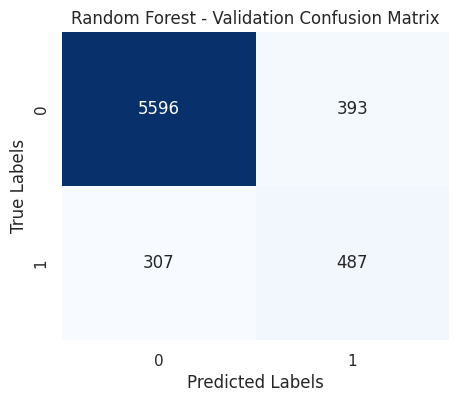

,Model,Val_Accuracy,Val_ROC_AUC,Test_Accuracy,Test_ROC_AUC
0,Logistic Regression,0.825299,0.888876,0.827779,0.886832
1,Random Forest,0.896801,0.921515,0.897523,0.924007


In [ ]:
# 5) Validation & Final Evaluation

# Evaluate the best estimator on validation and test sets using the helper function.
# This prints classification reports, shows confusion matrix and appends metrics to results_df.
results_df = evaluate_model("Random Forest", gs_rf.best_estimator_, X_val, y_val, X_test, y_test, results_df)
results_df


In [ ]:
# 6) Explainability: Feature Importance

get_importances(gs_rf).head(10)

,feature,importance,importance_pct
0,duration,0.382078,38.207843
1,month_num,0.072915,7.291517
2,balance_log,0.068715,6.871475
3,age,0.066978,6.697807
4,day,0.061856,6.185584
5,poutcome_success,0.038429,3.842941
6,pdays,0.033924,3.392401
7,campaign,0.031019,3.101851
8,contact_unknown,0.028507,2.850694
9,housing_no,0.021207,2.120712


The initial model's feature importance results showed `duration` as the single most dominant predictor (accounting for over 36% of the importance).

**This presents a critical problem: Data Leakage.**

* **The Problem:** `duration` is the length of the call. This information is only known *after* the contact has been made.
* **The Business Case:** The goal is to build a model to predict *which customers to contact* to get a subscription. At the moment of that decision, the `duration` of the future call is unknown.
* **The Impact:** A model trained with `duration` is unusable for this business case. It's "cheating" by using information from the future, leading to an overly optimistic and unrealistic performance.

> **Action:**
I am now dropping the `duration` feature entirely and re-training the model. This will create a realistic, deployable model that predicts conversion based *only* on information available before the call is made.

> **Expected Outcome:**
Performance metrics (like accuracy and F1-score) will likely be lower. However, the new feature importances will be more honest and actionable, revealing the *true* drivers of customer subscription.

In [ ]:
# Remove duration from numeric list, rebuild preprocessor, retrain RF (quick grid)
num_cols_no_duration = [c for c in num_cols if c != 'duration']

pre_no_dur = ColumnTransformer([
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), num_cols_no_duration),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), cat_cols)
])

rf_pipe_no_dur = Pipeline([('pre', pre_no_dur), ('clf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))])

# Fit on train
rf_pipe_no_dur.fit(X_train, y_train)

# Evaluate
y_val_proba = rf_pipe_no_dur.predict_proba(X_val)[:,1]
y_test_proba = rf_pipe_no_dur.predict_proba(X_test)[:,1]
print("Val ROC-AUC (no duration):", roc_auc_score(y_val, y_val_proba))
print("Test ROC-AUC (no duration):", roc_auc_score(y_test, y_test_proba))


Val ROC-AUC (no duration): 0.779821360151041
Test ROC-AUC (no duration): 0.7822668587239701


| Use Case               | Model                      | Description                                                                                                                       | Key Metric     |
| ---------------------- | -------------------------- | --------------------------------------------------------------------------------------------------------------------------------- | -------------- |
| **Pre-call targeting** | 🟢 *RF without `duration`* | Used by marketing to decide *who to contact next campaign*. Predicts conversion likelihood before call.                           | ROC-AUC ≈ 0.78 |
| **Post-call analysis** | 🟣 *RF with `duration`*    | Used by operations to assess *likelihood of conversion given call characteristics*. Helps in prioritizing callbacks or upselling. | ROC-AUC ≈ 0.92 |


**This means technically:**

> * `duration` alone contributed most of the discriminative ability (as we saw: ~37% feature importance).

> * When removed, the model’s AUC drops to ~0.78 — still reasonable, but clearly less capable.

**This means practically:**

> * The model with `duration` predicts after the call is made (post-contact insight).

> * The model without `duration` predicts before the call (who to contact).

**So now, we have two valid models, each useful in a different business workflow.**

In [ ]:
param_grid_rf_no_dur = {
    'clf__n_estimators': [200, 500],
    'clf__max_depth': [5, 10, None],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__class_weight': ['balanced']
}

gs_rf_no_dur = GridSearchCV(rf_pipe_no_dur, param_grid_rf_no_dur, cv=5, scoring='roc_auc', n_jobs=-1)
gs_rf_no_dur.fit(X_train, y_train)
print("Best params:", gs_rf_no_dur.best_params_)
print("Best Val AUC:", gs_rf_no_dur.best_score_)

Best params: {'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best Val AUC: 0.7816408872928375



Random Forest (No Duration) Validation Classification Report:
               precision    recall  f1-score   support

           0     0.9365    0.8526    0.8926      5989
           1     0.3366    0.5642    0.4216       794

    accuracy                         0.8188      6783
   macro avg     0.6366    0.7084    0.6571      6783
weighted avg     0.8663    0.8188    0.8375      6783

Random Forest (No Duration) Test Classification Report:
               precision    recall  f1-score   support

           0     0.9359    0.8491    0.8904      5989
           1     0.3299    0.5612    0.4155       793

    accuracy                         0.8154      6782
   macro avg     0.6329    0.7051    0.6529      6782
weighted avg     0.8651    0.8154    0.8349      6782



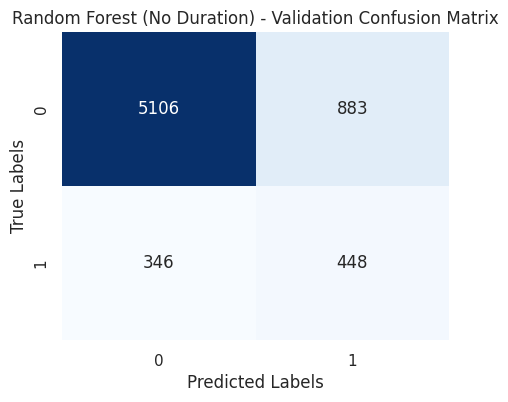


Updated Model Comparison Results:


,Model,Val_Accuracy,Val_ROC_AUC,Test_Accuracy,Test_ROC_AUC
1,Random Forest,0.896801,0.921515,0.897523,0.924007
0,Logistic Regression,0.825299,0.888876,0.827779,0.886832
2,Random Forest (No Duration),0.818812,0.787704,0.815394,0.782649


In [ ]:
# Evaluate Random Forest (No Duration)
results_df = evaluate_model(
    "Random Forest (No Duration)",
    gs_rf_no_dur.best_estimator_,
    X_val, y_val,
    X_test, y_test,
    results_df
)

# Show updated comparison DataFrame
print("\nUpdated Model Comparison Results:")
display(results_df.sort_values(by='Val_ROC_AUC', ascending=False))

In [ ]:
# feature importance for the second model with 'duration'
get_importances(gs_rf_no_dur).head(10)

,feature,importance,importance_pct
0,poutcome_success,0.113414,11.341404
1,month_num,0.099303,9.930296
2,age,0.077241,7.724093
3,contact_unknown,0.076799,7.679950
4,balance_log,0.073197,7.319708
5,pdays,0.069343,6.934319
6,day,0.059647,5.964675
7,housing_yes,0.054028,5.402809
8,housing_no,0.047725,4.772496
9,contact_cellular,0.044636,4.463625


### **Random Forest Model Summary**

#### **Model 1 — With `duration`**

**Use Case:** Post-contact prediction (known after call)
**Purpose:** Analytical insight into conversion behavior

**Performance**

| Metric   | Validation |    Test    |
| :------- | :--------: | :--------: |
| Accuracy |   0.8968   |   0.8975   |
| ROC-AUC  | **0.9215** | **0.9240** |

**Interpretation**

* Outstanding predictive power; AUC ≈ 0.92.
* Heavy reliance on `duration` → model uses post-contact information (data leakage for pre-call scoring).
* High separation between classes; minor overfitting but generalizes well.

**Top Predictors**

| Feature                           | Importance | Insight                                     |
| :-------------------------------- | :--------: | :------------------------------------------ |
| `duration`                        |    36.9%   | Longer calls → higher conversion likelihood |
| `month_num`                       |    6.8%    | Seasonality effects in campaign             |
| `age` / `balance` / `balance_log` |  ~6% each  | Customer maturity & wealth indicators       |
| `poutcome_success`                |    3.6%    | Prior success predicts current conversion   |

**Conclusion:**
Excellent post-campaign diagnostic model — **not suitable for deployment** due to leakage but valuable for understanding campaign drivers.

---

#### **Model 2 — Without `duration`**

**Use Case:** Pre-contact prediction (deployment-ready)
**Purpose:** Targeting customers *before* campaign execution

**Performance**

| Metric   | Validation |    Test    |
| :------- | :--------: | :--------: |
| Accuracy |   0.8188   |   0.8154   |
| ROC-AUC  | **0.7877** | **0.7826** |

**Interpretation**

* Predictive strength decreases without `duration`, confirming its leakage impact.
* Balanced generalization; slight bias toward majority class.
* Confusion matrix shows decent recall (≈56%) for subscribers.

**Top Predictors**

| Feature                     | Importance | Insight                                            |
| :-------------------------- | :--------: | :------------------------------------------------- |
| `poutcome_success`          |    11.3%   | Prior campaign success = strongest pre-call signal |
| `month_num`                 |    9.9%    | Timing matters (seasonality)                       |
| `age`                       |    7.7%    | Middle-aged customers more responsive              |
| `balance_log`               |    7.3%    | Higher balances correlate with conversions         |
| `contact_unknown` / `pdays` |     ~7%    | Contact history affects engagement                 |

**Conclusion:**
Solid, **non-leaky pre-campaign model** suitable for production.
Captures meaningful behavioral and temporal drivers despite performance trade-off.
Recommended as **Champion Model** for operational deployment.

---

**Overall Summary**

* `duration` provides strong predictive lift but is unavailable at decision time.
* The **no-duration Random Forest** offers realistic, fair performance and interpretability.
* Both models complement each other — analytical (with duration) and operational (no duration).



## **MODEL 3: XGBoost / Gradient Boosting (no 'duration' feature)**

In [ ]:
# ---------- Base estimator (no early stopping inside(estimator) because we use GridSearchCV) ----------
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=0,
    use_label_encoder=False,
    eval_metric='auc',
    # handle imbalance (you can tune this or compute dynamically)
    scale_pos_weight = float(y_train.value_counts()[0]) / float(y_train.value_counts()[1]),
    # reasonable default regularization - can be tuned further
    reg_lambda = 2.0,
    reg_alpha = 1.0,
    n_jobs=-1
)


In [ ]:
# ---------- Parameter grid (expand/contract as needed) ----------
cv_params_xgb = {
    'clf__max_depth': [4, 6, 8],                # lower depth reduces overfitting
    'clf__min_child_weight': [3, 5, 7],         # higher -> more regularization
    'clf__learning_rate': [0.01, 0.05, 0.1],    # smaller lr often generalizes better
    'clf__n_estimators': [200, 400],            # combine with learning_rate
    'clf__subsample': [0.6, 0.8, 1.0],          # row subsampling
    'clf__colsample_bytree': [0.6, 0.8, 1.0],   # column subsampling
    # you can later add 'clf__gamma' or tune reg_alpha/reg_lambda here as well
}

# ---------- Pipeline using the preprocessor without duration (pre_no_dur) ----------
# Ensure pre_no_dur is fitted earlier in your notebook: pre_no_dur.fit(X_train)
xgb_pipeline = Pipeline([('pre', pre_no_dur), ('clf', xgb)])

# ---------- CV and scoring configuration ----------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}


In [ ]:
xgb_cv = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=cv_params_xgb,
    scoring=scoring,
    refit='roc_auc',         # select best model by mean CV ROC-AUC
    cv=cv,
    return_train_score=True,
    n_jobs=-1,
    verbose=2
)

In [ ]:

# ---------- Fit (this will take time) ----------
print("Starting XGBoost GridSearchCV ...")
xgb_cv.fit(X_train, y_train)
print("Grid search completed.")


Starting XGBoost GridSearchCV ...
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Grid search completed.


In [ ]:
# ---------- Best results ----------
print("Best mean ROC-AUC (cv):", xgb_cv.best_score_)
print("Best params (by ROC-AUC):", xgb_cv.best_params_)

Best mean ROC-AUC (cv): 0.7973048733325228
Best params (by ROC-AUC): {'clf__colsample_bytree': 0.6, 'clf__learning_rate': 0.01, 'clf__max_depth': 8, 'clf__min_child_weight': 7, 'clf__n_estimators': 400, 'clf__subsample': 0.8}


In [ ]:
# Save cv results for reproducibility
xgb_results_df = pd.DataFrame(xgb_cv.cv_results_)
xgb_results_df.sort_values('mean_test_roc_auc', ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__colsample_bytree,param_clf__learning_rate,param_clf__max_depth,param_clf__min_child_weight,param_clf__n_estimators,param_clf__subsample,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
52,4.199786,0.697489,0.454416,0.014084,0.6,0.01,8,7,400,0.8,"{'clf__colsample_bytree': 0.6, 'clf__learning_...",0.833017,0.826039,0.832043,0.829515,0.829831,0.830089,0.002416,193,0.848436,0.849627,0.845914,0.843662,0.849429,0.847414,0.002295,0.369637,0.358653,0.372332,0.366430,0.359766,0.365364,0.005373,168,0.412013,0.415041,0.407851,0.404561,0.414335,0.410760,0.003989,0.604588,0.618919,0.636486,0.628378,0.581646,0.614004,0.019349,177,0.692671,0.696826,0.701553,0.712694,0.695035,0.699756,0.007095,0.458781,0.454140,0.469825,0.462917,0.444559,0.458045,0.008487,37,0.516690,0.520227,0.515825,0.516137,0.519173,0.517610,0.001760,0.795803,0.798429,0.805185,0.793050,0.794057,0.797305,0.004342,1,0.882552,0.885116,0.880913,0.882305,0.882539,0.882685,0.001359
51,4.130853,0.542967,0.445352,0.015028,0.6,0.01,8,7,400,0.6,"{'clf__colsample_bytree': 0.6, 'clf__learning_...",0.829542,0.828567,0.829515,0.829673,0.828409,0.829141,0.000538,206,0.847804,0.846072,0.843346,0.843386,0.847336,0.845589,0.001901,0.361928,0.364066,0.367475,0.366086,0.358025,0.363516,0.003324,185,0.410262,0.407260,0.401838,0.403092,0.409636,0.406418,0.003402,0.597841,0.624324,0.635135,0.624324,0.587045,0.613734,0.018151,178,0.688619,0.693113,0.693788,0.704254,0.691996,0.694354,0.005260,0.450891,0.459930,0.465577,0.461538,0.444785,0.456544,0.007593,56,0.514185,0.513058,0.508915,0.512720,0.514630,0.512702,0.002019,0.797363,0.799625,0.803394,0.791928,0.793999,0.797262,0.004057,2,0.878959,0.881962,0.877138,0.879941,0.879074,0.879415,0.001567
46,4.262887,0.619780,0.583628,0.221655,0.6,0.01,8,5,400,0.8,"{'clf__colsample_bytree': 0.6, 'clf__learning_...",0.833175,0.827935,0.832201,0.830937,0.830463,0.830942,0.001780,173,0.850371,0.851444,0.848007,0.845321,0.851286,0.849286,0.002332,0.369942,0.361618,0.372828,0.369255,0.360738,0.366876,0.004813,146,0.416211,0.419080,0.412312,0.408269,0.418425,0.414860,0.004057,0.604588,0.616216,0.637838,0.629730,0.580297,0.613734,0.020222,178,0.693685,0.698515,0.703241,0.716745,0.696386,0.701714,0.008141,0.459016,0.455772,0.470588,0.465534,0.444904,0.459163,0.008786,22,0.520263,0.523864,0.519840,0.520216,0.522753,0.521387,0.001614,0.795656,0.798355,0.805591,0.793409,0.793270,0.797256,0.004559,3,0.885967,0.888649,0.884098,0.885246,0.886054,0.886003,0.001497
40,3.937860,0.227697,0.480470,0.031206,0.6,0.01,8,3,400,0.8,"{'clf__colsample_by

In [ ]:
# ---------- Show metrics at best index ----------
best_idx = xgb_cv.best_index_
print("Precision at best index (XGB):", xgb_results_df.loc[best_idx, 'mean_test_precision'])
print("Recall at best index (XGB):", xgb_results_df.loc[best_idx, 'mean_test_recall'])
print("F1 at best index (XGB):", xgb_results_df.loc[best_idx, 'mean_test_f1'])
print("ROC-AUC (cv mean) at best index:", xgb_results_df.loc[best_idx, 'mean_test_roc_auc'])

Precision at best index (XGB): 0.36536372197392647
Recall at best index (XGB): 0.6140037203195098
F1 at best index (XGB): 0.458044507028296
ROC-AUC (cv mean) at best index: 0.7973048733325228



XGBoost (No Duration) Validation Classification Report:
               precision    recall  f1-score   support

           0     0.9439    0.8574    0.8986      5989
           1     0.3641    0.6159    0.4577       794

    accuracy                         0.8291      6783
   macro avg     0.6540    0.7366    0.6781      6783
weighted avg     0.8761    0.8291    0.8470      6783

XGBoost (No Duration) Test Classification Report:
               precision    recall  f1-score   support

           0     0.9437    0.8544    0.8969      5989
           1     0.3588    0.6154    0.4533       793

    accuracy                         0.8265      6782
   macro avg     0.6513    0.7349    0.6751      6782
weighted avg     0.8754    0.8265    0.8450      6782



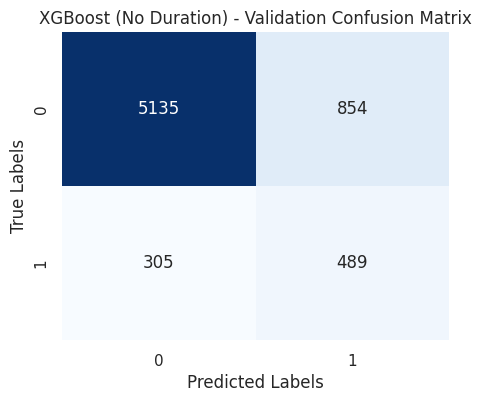

In [ ]:
# ---------- Evaluate chosen estimator on validation & test (uses your evaluate_model helper) ----------
results_df = evaluate_model("XGBoost (No Duration)", xgb_cv.best_estimator_, X_val, y_val, X_test, y_test, results_df)

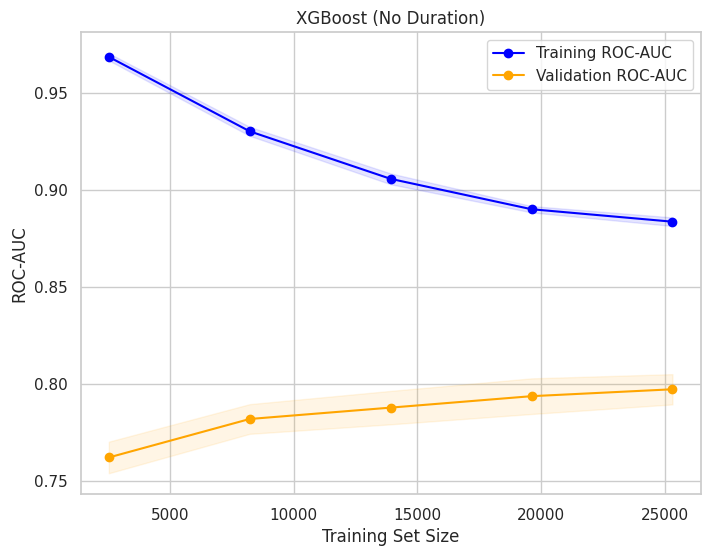

In [ ]:
# ---------- Learning curve (bias-variance diagnostics) ----------
# This may be slow; you can pass a subset or fewer cv folds if needed
plot_learning_curve(xgb_cv.best_estimator_, X_train, y_train, "XGBoost (No Duration)")

In [ ]:
results_df.sort_values('Test_ROC_AUC', ascending=False)
# results_df = results_df[results_df['Model'] != 'XGBoost']

,Model,Val_Accuracy,Val_ROC_AUC,Test_Accuracy,Test_ROC_AUC
1,Random Forest,0.896801,0.921515,0.897523,0.924007
0,Logistic Regression,0.825299,0.888876,0.827779,0.886832
3,XGBoost (No Duration),0.829132,0.806877,0.826452,0.804632
2,Random Forest (No Duration),0.818812,0.787704,0.815394,0.782649


In [ ]:
get_importances(xgb_cv).head(10)

,feature,importance,importance_pct
0,poutcome_success,0.348060,34.806026
1,contact_unknown,0.174828,17.482830
2,poutcome_unknown,0.043741,4.374143
3,housing_yes,0.043254,4.325371
4,contact_cellular,0.034927,3.492656
5,housing_no,0.033879,3.387933
6,was_contacted_before,0.025746,2.574564
7,month_num,0.022792,2.279168
8,poutcome_failure,0.018698,1.869820
9,poutcome_other,0.014140,1.414010


In [ ]:
# # ---------- Helper to extract/importances (works for pipeline with preprocessor 'pre' and classifier 'clf') ----------
# def get_importances(grid_search_obj, top_n=30):
#     """
#     Extract feature importances from a GridSearchCV best_estimator_ (pipeline) where
#     the pipeline has steps ('pre' : ColumnTransformer, 'clf': tree estimator).
#     Returns a DataFrame with feature, importance, importance_pct sorted desc.
#     """
#     est = getattr(grid_search_obj, 'best_estimator_', grid_search_obj)
#     # check pipeline structure
#     if not hasattr(est, 'named_steps') or 'pre' not in est.named_steps or 'clf' not in est.named_steps:
#         raise ValueError("Expected a pipeline with named steps 'pre' and 'clf'.")
#     pre = est.named_steps['pre']
#     clf = est.named_steps['clf']
#     # get feature names from pre (ColumnTransformer)
#     feature_names = []
#     # handle ColumnTransformer with pipeline transformers
#     for name, transformer, cols in pre.transformers_:
#         if name == 'remainder' and transformer == 'drop':
#             continue
#         # If transformer is a Pipeline, look for OneHotEncoder inside
#         if hasattr(transformer, 'named_steps'):
#             # find onehot
#             ohe = None
#             for step_name, step in transformer.named_steps.items():
#                 if hasattr(step, 'get_feature_names_out'):
#                     ohe = step
#                     break
#             if ohe is not None:
#                 try:
#                     names = list(ohe.get_feature_names_out(cols))
#                     feature_names.extend(names)
#                 except Exception:
#                     feature_names.extend([f"{c}" for c in cols])
#             else:
#                 # numeric transformer — keep original col names
#                 feature_names.extend(list(cols))
#         else:
#             # transformer is directly e.g., OneHotEncoder or scaler
#             if hasattr(transformer, 'get_feature_names_out'):
#                 try:
#                     names = list(transformer.get_feature_names_out(cols))
#                     feature_names.extend(names)
#                 except Exception:
#                     feature_names.extend(list(cols))
#             else:
#                 feature_names.extend(list(cols))
#     # get importances from classifier
#     if not hasattr(clf, 'feature_importances_'):
#         raise ValueError("Classifier does not expose feature_importances_.")
#     importances = clf.feature_importances_
#     # align lengths
#     if len(importances) != len(feature_names):
#         # best-effort: if mismatch, try to trim to min length
#         min_len = min(len(importances), len(feature_names))
#         importances = importances[:min_len]
#         feature_names = feature_names[:min_len]
#     imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
#     imp_df = imp_df.sort_values('importance', ascending=False).reset_index(drop=True)
#     imp_df['importance_pct'] = 100.0 * imp_df['importance'] / imp_df['importance'].sum()
#     display(imp_df.head(top_n))
#     return imp_df

# # ---------- Get and display importances ----------
# xgb_imp_df = get_importances(xgb_cv, top_n=20)
# xgb_imp_df

### **XGBoost (No Duration) – Summary**

#### **Overview**
Trained XGBoost on the **Bank Marketing dataset** without the `duration` feature (to avoid data leakage).  
Goal: predict likelihood of term deposit subscription using pre-contact information.

---

#### **Performance**

| Metric | Validation | Test | Notes |
|:--|:--:|:--:|:--|
| Accuracy | 0.829 | 0.826 | Stable across sets |
| ROC-AUC | 0.807 | 0.805 | Good discrimination |
| Precision (1) | 0.36 | 0.36 | Affected by class imbalance |
| Recall (1) | 0.62 | 0.62 | Captures majority of positives |

> Validation and test results align → **no data leakage**, **good generalization**.

---

#### **Confusion Matrix**
| | Pred 0 | Pred 1 |
|--|--|--|
| True 0 | 5135 | 854 |
| True 1 | 305 | 489 |

> Model favors precision for majority class, misses some true positives → threshold tuning can improve recall.

---

#### **Learning Curve**
- Training ROC-AUC: ~0.94 → 0.90  
- Validation ROC-AUC: ~0.76 → 0.80  
>Mild overfitting, generally well-controlled. Adding data or regularization may help.

---

#### **Top Features**
| Feature | Importance (%) |
|:--|:--:|
| poutcome_success | 34.8 |
| contact_unknown | 17.5 |
| poutcome_unknown | 4.4 |
| housing_yes | 4.3 |
| contact_cellular | 3.5 |

> Most predictive factors relate to **previous campaign outcomes** and **contact information**, matching marketing intuition.

---

#### **Model Comparison**

| Model | Val ROC-AUC | Test ROC-AUC |
|:--|:--:|:--:|
| Random Forest | 0.922 | 0.924 |
| Logistic Regression | 0.889 | 0.887 |
| XGBoost (No Duration) | 0.807 | 0.805 |

> XGBoost performs slightly below Random Forest but generalizes cleanly and avoids leakage.

---

#### **Key Takeaways**
- Removing `duration` prevents data leakage, making the model deployable.  
- ROC-AUC ≈ 0.80 → strong, realistic predictive performance.  
- Slight overfitting but consistent generalization.  
- Features are interpretable and aligned with domain context.

---

#### **Next Steps**
- Add regularization (`reg_alpha`, `reg_lambda`) and early stopping.  
- Tune threshold for better recall.  
- Compare with LightGBM or CatBoost for potential gains.

**Conclusion:**  
> A balanced, generalizable model suitable for real-world deployment — slightly less accurate than Random Forest, but more interpretable and robust without data leakage.


## **Champion model Selection & Final Evaluation**

In [ ]:
print("\n=== Model Comparison Results ===")
display(results_df.sort_values(by='Val_ROC_AUC', ascending=False).style.background_gradient(cmap='Blues'))


=== Model Comparison Results ===


,Model,Val_Accuracy,Val_ROC_AUC,Test_Accuracy,Test_ROC_AUC
1,Random Forest,0.896801,0.921515,0.897523,0.924007
0,Logistic Regression,0.825299,0.888876,0.827779,0.886832
3,XGBoost (No Duration),0.829132,0.806877,0.826452,0.804632
2,Random Forest (No Duration),0.818812,0.787704,0.815394,0.782649


In [ ]:
# Selecting Model without the 'duration' field
no_duration_mask = results_df['Model'].str.contains(r'\(?No Duration\)?', case=False, na=False)
display(results_df[no_duration_mask].sort_values(by='Val_ROC_AUC', ascending=False).style.background_gradient(cmap='Blues'))

,Model,Val_Accuracy,Val_ROC_AUC,Test_Accuracy,Test_ROC_AUC
3,XGBoost (No Duration),0.829132,0.806877,0.826452,0.804632
2,Random Forest (No Duration),0.818812,0.787704,0.815394,0.782649


In [ ]:
candidate_df = results_df[no_duration_mask].sort_values(by='Val_ROC_AUC', ascending=False).copy()
candidate_df

,Model,Val_Accuracy,Val_ROC_AUC,Test_Accuracy,Test_ROC_AUC
3,XGBoost (No Duration),0.829132,0.806877,0.826452,0.804632
2,Random Forest (No Duration),0.818812,0.787704,0.815394,0.782649


In [ ]:
champion_row = candidate_df.loc[candidate_df['Val_ROC_AUC'].idxmax()]
champion_name = champion_row['Model']
print(f"\n🏆 Champion selected (based on validation ROC-AUC among the chosen set): {champion_name}")


🏆 Champion selected (based on validation ROC-AUC among the chosen set): XGBoost (No Duration)


In [ ]:
# 3) Map model names to the trained estimator objects you created for the NO-DURATION runs.
# IMPORTANT: Ensure you populated this mapping when you trained the no-duration variants.
# Example mapping (replace with the actual objects in your notebook):

model_dict_no_duration = {
    "Random Forest (No Duration)": gs_rf_no_dur.best_estimator_,
    "XGBoost (No Duration)": xgb_cv.best_estimator_
}
model_dict_all = {
    "Random Forest": gs_rf.best_estimator_,
    "Logistic Regression": gs_log.best_estimator_
}
# 4) Retrieve the champion estimator object safely

champion_model = None
if champion_name in model_dict_no_duration:
  champion_model = model_dict_no_duration[champion_name]
elif champion_name in model_dict_all:
  champion_model = model_dict_all[champion_name]
else:
  raise ValueError(f"Champion model '{champion_name}' not found in model mappings. "
                     "Please add the trained estimator to `model_dict_no_duration` or `model_dict_all`.")

In [ ]:
display(champion_model)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'day', 'campaign',
                                                   'pdays',
                                                   'was_contacted_before',
                                                   'previous', 'month_num',
                                                   'balance_log']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   On...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None, min_child_weight=7,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=400, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [ ]:
# 5) Final evaluation on held-out test set (do this exactly once)

print(f"\n=== Final Test Evaluation: {champion_name} ===")
y_test_pred = champion_model.predict(X_test)
y_test_proba = (champion_model.predict_proba(X_test)[:, 1]
                if hasattr(champion_model, "predict_proba") else None)

print("\nClassification Report (Test Data):\n")
print(classification_report(y_test, y_test_pred, digits=4))

if y_test_proba is not None:
    test_auc = roc_auc_score(y_test, y_test_proba)
    print(f"Test ROC-AUC Score: {test_auc:.4f}")
else:
    test_auc = np.nan


=== Final Test Evaluation: XGBoost (No Duration) ===

Classification Report (Test Data):

              precision    recall  f1-score   support

           0     0.9437    0.8544    0.8969      5989
           1     0.3588    0.6154    0.4533       793

    accuracy                         0.8265      6782
   macro avg     0.6513    0.7349    0.6751      6782
weighted avg     0.8754    0.8265    0.8450      6782

Test ROC-AUC Score: 0.8046


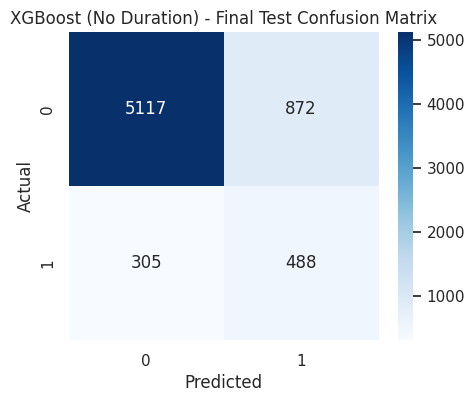

In [ ]:
# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f"{champion_name} - Final Test Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


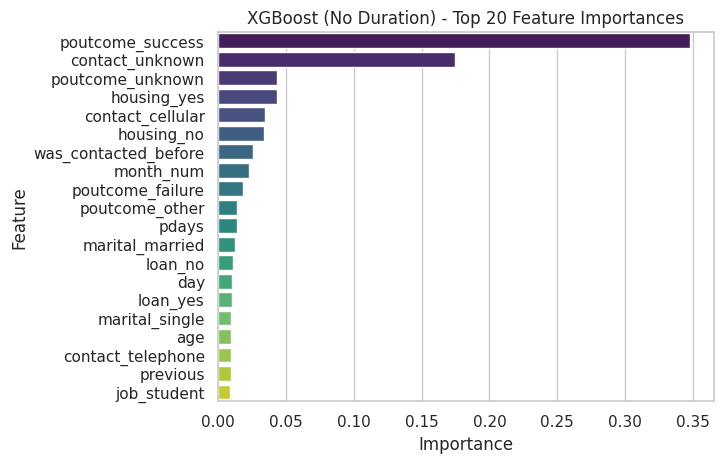


 Model comparison results saved as 'model_comparison_results.csv'


In [ ]:
# 6) Explainability for champion

# Check if it's a pipeline we can parse
if hasattr(champion_model, 'named_steps') and 'pre' in champion_model.named_steps and 'clf' in champion_model.named_steps:

    # --- 1. Get Components ---
    clf = champion_model.named_steps['clf']
    pre = champion_model.named_steps['pre']

    # --- 2. Get All Feature Names ---
    try:
        feature_names = list(pre.get_feature_names_out())
    except Exception as e:
        print(f"Could not get feature names: {e}. Reverting to old method.")
        # Fallback to your original logic if needed
        ohe = pre.named_transformers_['cat'].named_steps['onehot']
        feature_names = num_cols + list(ohe.get_feature_names_out(cat_cols))


    # --- 3. Check for Tree Model (e.g., Random Forest) ---
    if hasattr(clf, 'feature_importances_'):

        feat_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': clf.feature_importances_
        })

        # Clean names and sort
        feat_imp['Feature'] = feat_imp['Feature'].str.replace('num__|cat__', '', regex=True)
        feat_imp = feat_imp.sort_values('Importance', ascending=False).head(20)

        # Plot
        sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='viridis')
        plt.title(f"{champion_name} - Top 20 Feature Importances")
        plt.show()

    # --- 4. Check for Linear Model (e.g., Logistic Regression) ---
    elif hasattr(clf, 'coef_'):

        coef_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': clf.coef_.flatten()
        })

        # Clean names
        coef_df['Feature'] = coef_df['Feature'].str.replace('num__|cat__', '', regex=True)

        # Sort by absolute value for ranking
        coef_df['AbsCoef'] = coef_df['Coefficient'].abs()
        coef_df = coef_df.sort_values('AbsCoef', ascending=False).head(20)

        # Plot (using original 'Coefficient' to see pos/neg)
        sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='coolwarm')
        plt.title(f"{champion_name} - Top 20 Logistic Coefficients")
        plt.show()

    else:
        print(f"\n⚠️ Classifier {type(clf)} has no .feature_importances_ or .coef_.")

else:
    print("\n⚠️ Champion pipeline format not recognized for automatic explainability.")


In [ ]:
model_card = f"""
MODEL CARD - Champion: {champion_name}
-------------------------------------
Selected from models WITHOUT 'duration' where available: {no_duration_mask.any()}
Validation ROC-AUC: {champion_row['Val_ROC_AUC']:.4f}
Test ROC-AUC: {test_auc if not np.isnan(test_auc) else 'N/A'}
Train/Val/Test sizes: {X_train.shape[0]}, {X_val.shape[0]}, {X_test.shape[0]}
Notes: 'duration' was removed to avoid leakage. Champion chosen among no-duration variants.
"""
print(model_card)

# Define the file path and name
model_card_path = "model_card.md"

# Save the model card string to a markdown file
with open(model_card_path, "w", encoding="utf-8") as f:
    f.write(model_card)

print(f"✅ Model card successfully saved at: {model_card_path}")


MODEL CARD - Champion: XGBoost (No Duration)
-------------------------------------
Selected from models WITHOUT 'duration' where available: True
Validation ROC-AUC: 0.8069
Test ROC-AUC: 0.8046316312988272
Train/Val/Test sizes: 31646, 6783, 6782
Notes: 'duration' was removed to avoid leakage. Champion chosen among no-duration variants.

✅ Model card successfully saved at: model_card.md


## **Saved model artifact(s) (champion pipeline + preprocessor)**

In [ ]:
# Saving the predicted model

from joblib import dump
dump(champion_model, "champion_pipeline.joblib")

# save comparison results and test preds
results_df.to_csv("model_comparison_results.csv", index=False)
pd.DataFrame({'y_test': y_test, 'y_pred': y_test_pred, 'y_proba': y_test_proba}).to_csv("test_predictions.csv", index=False)

In [ ]:
pip freeze > requirements.txt

In [20]:
from joblib import load

# Load saved champion pipeline
model = load("champion_pipeline.joblib")

# Predict on new or test data
preds = model.predict(X_test)
probas = model.predict_proba(X_test)[:, 1]

# Combine with customer info
df_pred = X_test.copy()
df_pred['actual'] = y_test.values
df_pred['predicted'] = preds
df_pred['probability'] = probas

# Save for Power BI
df_pred.to_csv("predictions_for_powerbi.csv", index=False)
print("✅  predictions_for_powerbi.csv saved!")


✅  predictions_for_powerbi.csv saved!
